<a href="https://colab.research.google.com/github/danijak/CV_Project/blob/main/pollution_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM pollution forecasting 

In [1]:
#data loading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
cd drive/My Drive

/content/drive/My Drive


# Dependencies needed

In [10]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler  



#data processing

In [6]:
def dateformat(x):
  return datetime.strptime(x, '%Y %m %d %H')
data=pd.read_csv('pollution_dataset.csv', parse_dates= [['year','month','day','hour']], index_col=0, date_parser=dateformat)

In [7]:
data.head()


,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [8]:
# To clean NA from top rows and datetime formatting
data.drop('No', axis=1, inplace=True)
data.columns= ['pollution','dew', 'temp', 'pres', 'wind_dir','wind_speed', 'snow', 'rain']
data.index.name= 'date'
data=data[24:]
data['pollution'].fillna(0, inplace=True)
data.head()


,pollution,dew,temp,pres,wind_dir,wind_speed,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


#plottig the data

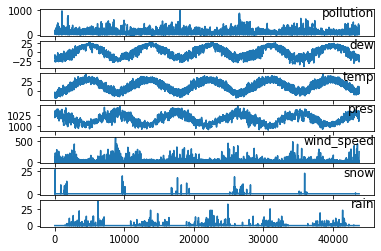

In [9]:
columns = [0,1,2,3,5,6,7]
i=1
plt.figure()
for column in columns:
  plt.subplot(len(columns), 1, i)
  plt.plot(data.values[:, column])
  plt.title(data.columns[column], y= 0.5, loc='right')
  i+=1
plt.show()


In [22]:
# convert time series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars= 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = [], []
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
     names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
   agg.dropna(inplace=True)
  return agg
 
values = data.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [24]:
# split
values=reframed.values
n_train_hours = 4*365*24
train = values[:n_train_hours, :]
test = values[n_train_hours:,:]
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]
#format 3d for lstm
train_X= train_X.reshape((train_X.shape[0],1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [26]:
# model
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
487/487 - 3s - loss: 0.0383 - val_loss: 0.0390
Epoch 2/50
487/487 - 1s - loss: 0.0145 - val_loss: 0.0175
Epoch 3/50
487/487 - 1s - loss: 0.0140 - val_loss: 0.0135
Epoch 4/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0133
Epoch 5/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0133
Epoch 6/50
487/487 - 1s - loss: 0.0140 - val_loss: 0.0133
Epoch 7/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0135
Epoch 8/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0138
Epoch 9/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 10/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 11/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 12/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0136
Epoch 13/50
487/487 - 1s - loss: 0.0139 - val_loss: 0.0134
Epoch 14/50
487/487 - 1s - loss: 0.0138 - val_loss: 0.0136
Epoch 15/50
487/487 - 1s - loss: 0.0138 - val_loss: 0.0134
Epoch 16/50
487/487 - 1s - loss: 0.0138 - val_loss: 0.0134
Epoch 17/50
487/487 - 1s - loss: 0.0138 - val_loss: 0.0133
Epoch 

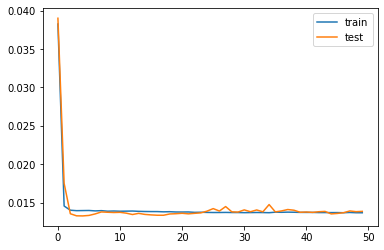

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

In [36]:
#predict
test_X = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.460
